In [ ]:
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, LSTM, Conv2D, Conv1D, Flatten, BatchNormalization, Dropout, Reshape, Activation, Input, GlobalAveragePooling1D, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/(데이콘)소설작가분류/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/(데이콘)소설작가분류/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/(데이콘)소설작가분류/sample_submission.csv', encoding = 'utf-8')

In [ ]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text'] = train['text'].apply(alpha_num)

In [ ]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [ ]:
vocab_size = 20000
embedding_dim = 20
max_length = 500

In [ ]:
train_i = [train[train['author'] == i] for i in range(5)]
word_index_i = []
train_padded_i = []
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index
for i in range(5):
  sequences = list()
  for line in train_i[i]['text']:
    new_line = tokenizer.texts_to_sequences([line])[0] #shape(-1,1) >> (-1)
    for i in range(1, len(new_line)):
      sequence = new_line[:i+1]
      sequences.append(sequence)
  train_padded_i.append(pad_sequences(sequences, padding='pre', maxlen=max_length+1)) # 문장의 가장오른쪽 하나는 y

X_i = [train_padded_i[i][:,:-1] for i in range(5)]
Y_i = [train_padded_i[i][:,-1] for i in range(5)]

In [ ]:
Y_i[0].shape

(217891,)

In [ ]:
seq_3r = []
for line in test['text']:
  new_line = tokenizer.texts_to_sequences([line])[0] #shape(-1,1) >> (-1)
  seq_2r = []
  for i in range(1, len(new_line)):
    seq_1r = new_line[:i+1]
    seq_2r.append(seq_1r)
  seq_3r.append(seq_2r)

tX_3r = []
tY_2r = []
for seq_2r in seq_3r:
  test_2r = pad_sequences(seq_2r, padding='pre', maxlen=max_length+1)
  tX_3r.append(test_2r[:,:-1])
  tY_2r.append(test_2r[:,-1])


# test_sequences = tokenizer.texts_to_sequences(test['text'])
# test_padded = pad_sequences(test_sequences, padding='pre', maxlen=max_length)

In [ ]:
data_i = [[s.split() for s in train_i[i]['text']] for i in range(5)]

w2v_i = [Word2Vec(data_i[i],         # 리스트 형태의 데이터
                 sg=1,         # 0: CBOW, 1: Skip-gram
                 size=20,     # 벡터 크기
                 window=3,     # 고려할 앞뒤 폭(앞뒤 3단어)
                 min_count=2,  # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers=4)    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
                 for i in range(5)]

In [ ]:
# NUM_WORDS, EMB_DIM = model.wv.vectors.shape
# emb = Embedding(input_dim=NUM_WORDS, output_dim=EMB_DIM, input_length=max_length,
#                 trainable=False, weights=[model.wv.vectors])
# model.wv.vectors.shape

(25551, 20)

In [ ]:
def gen_model():
  global vocab_size, embedding_dim, max_length
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
  model.add(LSTM(1000, kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(vocab_size, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model_i = [gen_model() for _ in range(5)]


In [ ]:
model_i[0].summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 20)           400000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 1000)              4084000   
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 20000)             20020000  
Total params: 24,508,000
Trainable params: 24,506,000
Non-trainable params: 2,000
_________________________________________________________________


In [ ]:
!rm -r /content/model0
!rm -r /content/model1
!rm -r /content/model2
!rm -r /content/model3
!rm -r /content/model4

for i in range(5):
  # 모델 폴더를 생성합니다.
  model_path = './model%d/'%i
  if not os.path.exists(model_path):
    os.mkdir(model_path)

  # Validation 점수가 가장 좋은 모델만 저장합니다.
  model_file_path = model_path + 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
  checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

  # 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  history = model_i[i].fit(X_i[i], Y_i[i], 
                    epochs=100, verbose=1, 
                    validation_split=0.2,
                    # batch_size=128,
                    callbacks=[checkpoint, early_stopping]
                    )

rm: cannot remove '/content/model1': No such file or directory
rm: cannot remove '/content/model2': No such file or directory
rm: cannot remove '/content/model3': No such file or directory
rm: cannot remove '/content/model4': No such file or directory
Epoch 1/100
5448/5448 [==============================] - ETA: 0s - loss: 7.8452 - accuracy: 0.0412
Epoch 00001: val_loss improved from inf to 31.88221, saving model to ./model0/Epoch_001_Val_31.882.hdf5
5448/5448 [==============================] - 1029s 189ms/step - loss: 7.8452 - accuracy: 0.0412 - val_loss: 31.8822 - val_accuracy: 0.0309
Epoch 2/100
5448/5448 [==============================] - ETA: 0s - loss: 7.4818 - accuracy: 0.0472

KeyboardInterrupt: ignored

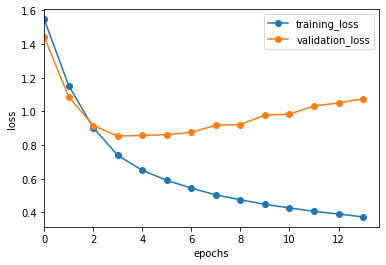

In [ ]:
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
avg_2r = []
for i in range(5):
  avg_1r = []
  for tX_2r, tY_1r in list(zip(tX_3r,tY_2r)):
    y_hat_1r = model_i[i].predict(tX_2r)
    tot = 0
    for y_hat_0r, tY_0r in list(zip(y_hat_1r, tY_1r)):
      try:
        score = w2v_i[i].wv.similarity(word_index[y_hat_0r], word_index[tY_0r])
        tot += score
      except:
        pass
    avg_0r = tot/len(y_hat_1r)
    avg_1r.append(avg_0r)
  avg_2r.append(avg_1r)

avg_2r = list(zip(*avg_2r))

In [ ]:
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

fin_2r = list(map(softmax, avg_2r))

In [ ]:
sample_submission[['0','1','2','3','4']] = fin_2r
sample_submission

In [ ]:
sample_submission.to_csv('submission.csv', index = False, encoding = 'utf-8')

In [ ]:
w2v_i[0].wv.similarity('queen', 'aaaa')

NameError: ignored

In [11]:
import numpy as np
np.random.rand()

0.8032613710090145